<a href="https://colab.research.google.com/github/abyaadrafid/LDA_Lab_Defence/blob/main/LegalBertClaudette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DEBUG = False
LR = 5e-2
EPOCHS = 5
BS = 16

In [2]:
from google.colab import drive
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import WeightedRandomSampler
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install torch-lr-finder
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from tqdm import tqdm_notebook
from transformers import BertTokenizer

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
MODEL_NAME = 'nlpaueb/legal-bert-small-uncased'
EMBEDDING_SIZE = 512

In [7]:
def get_sentences(path):
    sentences= []
    for filename in os.listdir(path):
        with open(path+filename, 'r') as f:
            for sentence in f :
                sentences.append(sentence)
    return sentences

In [8]:
def get_labels(path):
    all_labels = []
    for filename in os.listdir(path):
        file_labels = []
        with open(path+filename, 'r') as f:
            for label in f :
                all_labels.append(int(label))
    return all_labels

In [9]:
all_sentences = get_sentences("/content/drive/MyDrive/Sentences/")

In [10]:
all_labels = get_labels("/content/drive/MyDrive/Labels/")

In [11]:
if DEBUG : 
  all_sentences = all_sentences[:2000]
  all_labels = all_labels[:2000]

In [12]:
all_labels =  [0 if label ==-1 else label for label in all_labels]

In [13]:
labels_df = pd.DataFrame(all_labels, columns=['label'])

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,sentences ,labels):

        self.labels = labels
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in tqdm_notebook(all_sentences)]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [15]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [16]:
dataset = Dataset(all_sentences, all_labels)

  0%|          | 0/9414 [00:00<?, ?it/s]

In [17]:
dataset_size = dataset.__len__()
train_count = int(dataset_size * 0.8)
valid_count = dataset_size - train_count

In [18]:
train_ds, valid_ds = random_split(dataset, [train_count, valid_count])

In [19]:
y_train_indices = train_ds.indices

y_train = [dataset.labels[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [20]:
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [21]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [22]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(EMBEDDING_SIZE, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.sigmoid((self.linear(dropout_output)))

        return linear_output

In [23]:
use_cuda = torch.cuda.is_available()

In [24]:
device = torch.device("cuda" if use_cuda else "cpu")

In [25]:
model = BertClassifier().to(device)

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BS, sampler = sampler)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BS)

In [27]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [28]:
def train_loop(n_epochs) :
  tr_metrics = []
  va_metrics = []
  for epoch in tqdm_notebook(range(n_epochs)) :
    train_loss = 0.0
    train_acc = 0.0
    train_f1 = 0.0
    train_precision = 0.0
    train_recall = 0.0
    model.train()
    for inputs, targets in tqdm_notebook(train_dl) :
      targets = targets.to(device)
      masks = inputs['attention_mask'].to(device)
      input_ids = inputs['input_ids'].squeeze(1).to(device)
      outputs = model(input_ids, masks)
      outputs = outputs.squeeze(1)
      targets = targets.to(torch.float32)

      loss = criterion(outputs, targets)
      train_loss += loss
      acc = (outputs.detach().cpu().numpy().round() == targets.cpu().numpy()).sum().item()
      f1 = f1_score(outputs.detach().cpu().numpy().round(), targets.cpu().numpy(), average = 'weighted')
      precision = precision_score(outputs.detach().cpu().numpy().round(), targets.cpu().numpy(), average = 'weighted')
      recall = recall_score(outputs.detach().cpu().numpy().round(), targets.cpu().numpy(), average = 'weighted')
      train_acc += acc
      train_f1+= f1
      train_precision += precision
      train_recall += recall

      model.zero_grad()
      loss.backward()
      optimizer.step()

    valid_loss = 0.0
    valid_acc = 0.0
    valid_f1 = 0.0
    valid_precision = 0.0
    valid_recall = 0.0

    model.eval()
    with torch.no_grad():
      for inputs, targets in tqdm_notebook(valid_dl) :
        targets = targets.to(device)
        masks = inputs['attention_mask'].to(device)
        input_ids = inputs['input_ids'].squeeze(1).to(device)
        outputs = model(input_ids, masks)
        
        outputs = outputs.squeeze(1)
        targets = targets.to(torch.float32)

        loss = criterion(outputs, targets)
        valid_loss += loss
        acc = (outputs.detach().cpu().numpy().round() == targets.cpu().numpy()).sum().item()
        f1 = f1_score(outputs.detach().cpu().numpy().round(), targets.detach().cpu().numpy(), average = 'weighted')
        precision = precision_score(outputs.detach().cpu().numpy().round(), targets.cpu().numpy(), average = 'weighted')
        recall = recall_score(outputs.detach().cpu().numpy().round(), targets.cpu().numpy(), average = 'weighted')
        valid_acc += acc
        valid_f1+= f1
        valid_precision += precision
        valid_recall += recall
    print(
        f'Epoch {epoch+1} : \n\
        Train_loss : {train_loss/len(train_ds)}\n\
        Train_acc : {train_acc/len(train_ds)}\n\
        Train_F1 : {train_f1/len(train_ds)}\n\
        Train_precision : {train_precision/len(train_ds)}\n\
        Train_recall : {train_recall/len(train_ds)}\n\
        Valid_loss : {valid_loss/len(valid_ds)}\n\
        Valid_acc : {valid_acc/len(valid_ds)}\n\
        Valid_F1 : {valid_f1/len(valid_ds)}\n\
        Valid_precision : {valid_precision/len(valid_ds)}\n\
        Valid_recall : {valid_recall/len(valid_ds)}'
      )

    tr_metrics.append((train_loss/len(train_ds),train_acc/len(train_ds),train_f1/len(train_ds),train_precision/len(train_ds),train_recall/len(train_ds)))
    va_metrics.append((valid_loss/len(valid_ds),valid_acc/len(valid_ds),valid_f1/len(valid_ds),valid_precision/len(valid_ds),valid_recall/len(valid_ds)))

  return tr_metrics, va_metrics

In [29]:
tr_metrics, va_metrics = train_loop(EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1 : 
        Train_loss : 0.1339489370584488
        Train_acc : 0.5032532200239012
        Train_F1 : 0.03462738487179127
        Train_precision : 0.04358307917056758
        Train_recall : 0.03147218768484205
        Valid_loss : 0.212227001786232
        Valid_acc : 0.11099309612320765
        Valid_F1 : 0.011959138552464183
        Valid_precision : 0.053106744556558685
        Valid_recall : 0.006982329937720273


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2 : 
        Train_loss : 0.1224481388926506
        Train_acc : 0.5029876510423582
        Train_F1 : 0.03384368503199809
        Train_precision : 0.04149838958733033
        Train_recall : 0.031466906483504545
        Valid_loss : 0.022206181660294533
        Valid_acc : 0.8890069038767924
        Valid_F1 : 0.058833634182255096
        Valid_precision : 0.06266595857673925
        Valid_recall : 0.055683628639018976


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3 : 
        Train_loss : 0.1559181958436966
        Train_acc : 0.5093613065993892
        Train_F1 : 0.03512894329387508
        Train_precision : 0.04416831066512383
        Train_recall : 0.03185394309581005
        Valid_loss : 0.0417780801653862
        Valid_acc : 0.8890069038767924
        Valid_F1 : 0.058833634182255096
        Valid_precision : 0.06266595857673925
        Valid_recall : 0.055683628639018976


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4 : 
        Train_loss : 0.1306370496749878
        Train_acc : 0.5029876510423582
        Train_F1 : 0.034070752547341245
        Train_precision : 0.04180596394819272
        Train_recall : 0.031459361910165254
        Valid_loss : 0.297212690114975
        Valid_acc : 0.11099309612320765
        Valid_F1 : 0.011959138552464183
        Valid_precision : 0.053106744556558685
        Valid_recall : 0.006982329937720273


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5 : 
        Train_loss : 0.1499580591917038
        Train_acc : 0.48559288275129464
        Train_F1 : 0.033573170390620855
        Train_precision : 0.0426661755425781
        Train_recall : 0.03037218889197378
        Valid_loss : 0.026939062401652336
        Valid_acc : 0.8890069038767924
        Valid_F1 : 0.058833634182255096
        Valid_precision : 0.06266595857673925
        Valid_recall : 0.055683628639018976


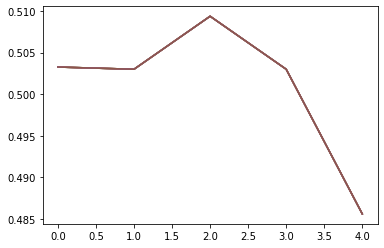

In [31]:
plt.plot(list(map(lambda t:t[0], tr_metrics)))

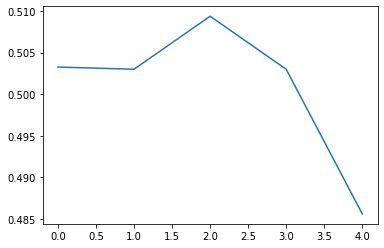

In [32]:
plt.plot(list(map(lambda t:t[1], tr_metrics)))

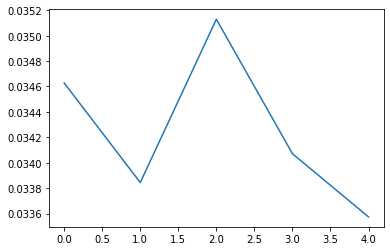

In [33]:
plt.plot(list(map(lambda t:t[2], tr_metrics)))

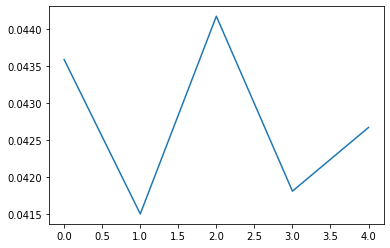

In [34]:
plt.plot(list(map(lambda t:t[3], tr_metrics)))

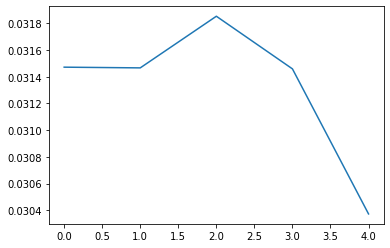

In [35]:
plt.plot(list(map(lambda t:t[4], tr_metrics)))


In [ ]:
plt.plot(list(map(lambda t:t[1], tr_metrics)))
